# Utilisation du package GeoNetworkX pour l'analyse géospatiale des stations IRVE

## Objectif

Fournir un outil pour:
- Analyser l'adéquation du réseau de recharge autoroutier au trafic de VE
- Fournir des indicateurs de la qualité de l'infrastructure et de son usage

In [1]:
#import os
#os.chdir(r"D:\philippe\python ESstandard\geonetworkx")

#os.getcwd()

In [2]:
import sys

new_path = r"D:\philippe\python ESstandard\geonetworkx"
sys.path.append(new_path)

In [3]:
from shapely import LineString, Point
import numpy as np
import geopandas as gpd

import geonetworkx as gnx
from geonetworkx import geom_to_crs, cast_id

## Initialisation du réseau (noeuds et troncons)

In [4]:
paris = Point(2.3514, 48.8575)
lyon = Point(4.8357, 45.7640)
marseille = Point(5.3691, 43.3026)
avignon = Point(4.8059, 43.9487)
bordeaux = Point(-0.56667, 44.833328)
toulouse = Point(1.43333, 43.599998)

nd = np.array([[1, 'paris', paris],
               [2, 'lyon', lyon],
               [3, 'marseille', marseille],
               [4, 'bordeaux', bordeaux],
               [5, 'toulouse', toulouse]])
noeuds = gpd.GeoDataFrame({'node_id': nd[:, 0], 'city': nd[:, 1], 'geometry': nd[:, 2], 'type': 'noeud'}, 
                          crs=4326).to_crs(2154)

tr = np.array([[1, 2], [2, 3], [1, 4], [4, 5]])
troncons = gpd.GeoDataFrame({'source': tr[:, 0], 'target': tr[:, 1]})
troncons['type'] = 'road'

## Restitution du réseau

{'crs': 2154} {'crs': 2154}
   source  target                                           geometry  \
0       1       2  LINESTRING (652411.148 6862135.813, 842666.659...   
1       1       4  LINESTRING (652411.148 6862135.813, 418208.312...   
2       2       3  LINESTRING (842666.659 6519924.367, 892313.068...   
3       4       5  LINESTRING (418208.312 6421272.355, 573469.736...   

          weight  type  
0  391542.888918  road  
1  499210.934404  road  
2  276703.255780  road  
3  210495.432002  road  
        city                        geometry   type  node_id
0      paris  POINT (652411.148 6862135.813)  noeud        1
1       lyon  POINT (842666.659 6519924.367)  noeud        2
2  marseille  POINT (892313.068 6247711.351)  noeud        3
3   bordeaux  POINT (418208.312 6421272.355)  noeud        4
4   toulouse  POINT (573469.736 6279137.851)  noeud        5


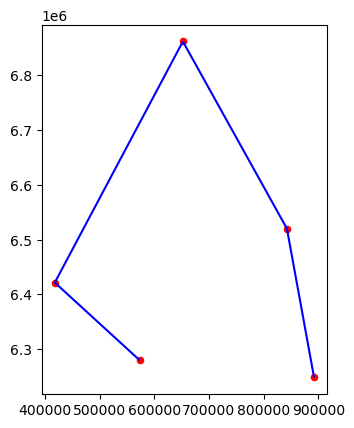

In [5]:
gr = gnx.from_geopandas_edgelist(troncons, edge_attr=True, node_gdf=noeuds)

print(gr.to_geopandas_edgelist())
print(gr.to_geopandas_nodelist())
gr.plot(edgecolor='blue', markersize=20)

In [6]:
param_exp = {'e_tooltip': "type", 'e_popup': ['type', 'weight', 'source', 'target'], 
             'e_name': 'troncons', 'n_tooltip': "city", 'n_popup': ['city', 'node_id']}
gr.explore(**param_exp)

## Ajout du noeud 'avignon'

In [7]:

avi_2154 = geom_to_crs(avignon, 4326, 2154)
id_edge = gr.find_edge(avi_2154, 200000)
if id_edge:
    dist = gr.insert_node(avi_2154, max(gr.nodes)+1, id_edge, 
                          att_node={'city': 'avignon'}, adjust=True)
gr.explore(**param_exp)

## Ajout des stations

In [8]:
np_st = np.array([['st1', 'orange', Point(4.8, 44.1)],
                 ['st2', 'avignon', Point(4.7, 43.9)]])
stat = gpd.GeoDataFrame({'node_id': np_st[:, 0], 'city': np_st[:, 1], 'geometry': np_st[:, 2], 'type': 'irve'}, 
                          crs=4326).to_crs(2154)
stat

,node_id,city,geometry,type
0,st1,orange,POINT (844105.386 6335086.609),irve
1,st2,avignon,POINT (836579.2 6312691.87),irve


In [9]:
np_st = [('st1', {'adress': 'orange', 'geometry': geom_to_crs(Point(4.8, 44.1), 4326, 2154), 'type': 'irve'}),
         ('st2', {'adress': 'avignon', 'geometry':geom_to_crs(Point(4.78, 43.95), 4326, 2154), 'type': 'irve'})]

for station in np_st:
    geo_st = station[1]['geometry'].centroid
    id_node = gr.find_node(geo_st, 5000)
    print('id_node : ', id_node)
    if not id_node:
        id_edge = gr.find_edge(geo_st, 5000)
        print('id_edge : ', id_edge)
        if id_edge:
            id_node = max(cast_id(gr.nodes))+1
            dist = gr.insert_node(geo_st, id_node, id_edge, att_node={'city': 'inserted'}, adjust=False) 
        else:
            continue
    dis1 = geo_st.distance(gr.nodes[id_node]['geometry'])
    geo1 = LineString([gr.nodes[id_node]['geometry'], geo_st])
    gr.add_node(station[0], **station[1])
    gr.add_edge(id_node, station[0], **{'geometry':geo1, 'weight': dis1, 'type': 'st_irve'})
  
print(gr.to_geopandas_nodelist())    
print(gr.to_geopandas_edgelist())   
gr.explore(**param_exp)

id_node :  None
id_edge :  [2, 6]
id_node :  6
        city                        geometry   type   adress node_id
0      paris  POINT (652411.148 6862135.813)  noeud      NaN       1
1       lyon  POINT (842666.659 6519924.367)  noeud      NaN       2
2  marseille  POINT (892313.068 6247711.351)  noeud      NaN       3
3   bordeaux  POINT (418208.312 6421272.355)  noeud      NaN       4
4   toulouse  POINT (573469.736 6279137.851)  noeud      NaN       5
5    avignon  POINT (844962.091 6318290.737)    NaN      NaN       6
6   inserted  POINT (844105.386 6335086.609)    NaN      NaN       7
7        NaN  POINT (844105.386 6335086.609)   irve   orange     st1
8        NaN   POINT (842880.16 6318387.943)   irve  avignon     st2
   source target                                           geometry  \
0       1      2  LINESTRING (652411.148 6862135.813, 842666.659...   
1       1      4  LINESTRING (652411.148 6862135.813, 418208.312...   
2       2      7  LINESTRING (842666.659 6519924.3